<a href="https://colab.research.google.com/github/AritraStark/Vision-Transformer-classification/blob/main/E2E_eval_task_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Topic: Vision Transformer classification**

**Datasets**:

* https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc (Photons)
* https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA (Electrons)

**Description:** 32x32 matrices (two channels - hit energy and time) for two classes of particles electrons and photons impinging on a calorimeter A Vision Transformer model to classify them.

Downloading the dataset:

In [ ]:
!wget https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc/download -O photons.hdf5
!wget https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA/download -O electrons.hdf5

--2022-04-04 01:45:59--  https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.28, 188.184.97.72, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119703858 (114M) [application/octet-stream]
Saving to: ‘photons.hdf5’

photons.hdf5        100%[===================>] 114.16M  27.4MB/s    in 4.8s    

Last-modified header invalid -- time-stamp ignored.
2022-04-04 01:46:06 (23.6 MB/s) - ‘photons.hdf5’ saved [119703858/119703858]

--2022-04-04 01:46:06--  https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.28, 188.184.97.72, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128927319 (123M) [application/octet-stream]
Saving to: ‘electrons.hdf5’

elect

Setting up imports:

In [ ]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 27.4 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, roc_auc_score
import tensorflow_addons as tfa
from sklearn.metrics import classification_report

Get the data from the downloaded HDF5 files and combine the loaded datasets:

In [ ]:
X_electron = np.array(h5py.File("electrons.hdf5",'r').get(name="X")[()])
y_electron = np.array(h5py.File("electrons.hdf5",'r').get(name="y")[()])
X_photon = np.array(h5py.File("photons.hdf5",'r').get(name="X")[()])
y_photon = np.array(h5py.File("photons.hdf5",'r').get(name="y")[()])

X_particles = np.concatenate((X_electron,X_photon),axis=0)
y_particles = np.concatenate((y_electron,y_photon),axis=0)
print(X_particles.shape,y_particles.shape)

del X_electron
del X_photon
del y_electron
del y_photon

rand_seed = 263
index = np.random.permutation(len(y_particles))
X_particles, y_particles = X_particles[index][:,:,:,0], y_particles[index]

(498000, 32, 32, 2) (498000,)


Splitting the data into training and testing sets ( I have split it in 80-20 as per instructions):



In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split( X_particles, y_particles, random_state=20, test_size=0.2 )
#del stream_data
del X_particles
del y_particles

Configuring the hyperparameters



In [ ]:
num_classes = 1
input_shape = (32, 32, 1)
learning_rate = 0.0015
batch_size = 64
num_epochs = 20
image_size = 32 # size for resize image
patch_size = 8  # size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 1
mlp_head_units = [1024, 512] 

Defining data augmentations:



In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        tf.keras.layers.Resizing(image_size, image_size),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

Implementing multilayer perceptron (MLP):



In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

Implementing patch creation as a layer:



In [ ]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Implementing the patch encoding layer:



In [ ]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

Defining the Vision Transformer (ViT) model:



In [ ]:
def create_vit_classifier():
    inputs = tf.keras.layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = tf.keras.layers.Flatten()(representation)
    representation = tf.keras.layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = tf.keras.layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

Compiling, training and evaluating the model:



In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay = weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5),
            tf.keras.metrics.AUC(from_logits=True),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="binary_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=Y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.2,
        callbacks=[checkpoint_callback],
        shuffle = True
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, auc = model.evaluate(X_test, Y_test)
    print(f"Test accuracy: {accuracy}")
    print(f"Test AUC: {auc}")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/20
4980/4980 [==============================] - 46s 9ms/step - loss: 0.6892 - binary_accuracy: 0.5227 - auc_1: 0.5694 - val_loss: 0.6720 - val_binary_accuracy: 0.5226 - val_auc_1: 0.6393
Epoch 2/20
4980/4980 [==============================] - 44s 9ms/step - loss: 0.6762 - binary_accuracy: 0.5454 - auc_1: 0.6045 - val_loss: 0.6648 - val_binary_accuracy: 0.5502 - val_auc_1: 0.6546
Epoch 3/20
4980/4980 [==============================] - 43s 9ms/step - loss: 0.6696 - binary_accuracy: 0.5542 - auc_1: 0.6247 - val_loss: 0.6522 - val_binary_accuracy: 0.5513 - val_auc_1: 0.6764
Epoch 4/20
4980/4980 [==============================] - 43s 9ms/step - loss: 0.6639 - binary_accuracy: 0.5635 - auc_1: 0.6388 - val_loss: 0.6572 - val_binary_accuracy: 0.5757 - val_auc_1: 0.6815
Epoch 5/20
4980/4980 [==============================] - 43s 9ms/step - loss: 0.6609 - binary_accuracy: 0.5679 - auc_1: 0.6464 - val_loss: 0.6479 - val_binary_accuracy: 0.5626 - val_auc_1: 0.6870
Epoch 6/20
4980/4980 [===

Predict on the validation data and load the best saved weight:



In [ ]:
predictions = vit_classifier.predict(X_test)
temp_predictions = []
for i in range(len(predictions)):
    k = np.argmax(predictions[i])
    temp_predictions.append(k)

temp_predictions = np.array(temp_predictions)

Plotting accuracy and loss curves:



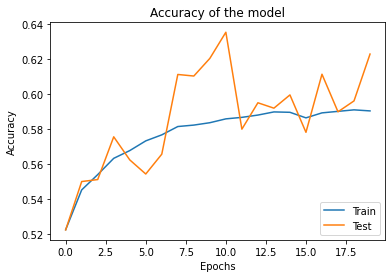

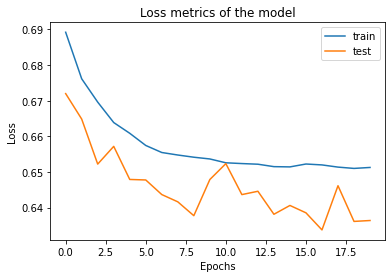

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy of the model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss metrics of the model')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
bin =[0 if p<0.5 else 1 for p in predictions]
print("ROC AUC:")
roc_auc_score(Y_test, bin)

ROC AUC:


0.5957598802398181

Plotting the ROC AUC curve:



No handles with labels found to put in legend.


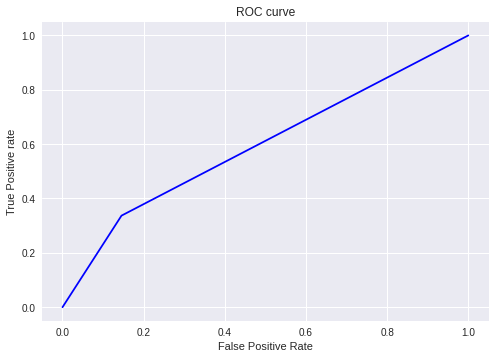

In [ ]:
fpr, tpr, thresh = roc_curve(Y_test, bin, pos_label=1)
plt.style.use('seaborn')
plt.plot(fpr, tpr,color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();